# **Ensemble Modelling**

Ensemble Model is a machine learning approach for combining different models in a prediction process. These models are called base estimators. This is a solution to overcome the technical problem of building a single estimator:

**High variance**: The model is very sensitive to the input provided to the learned features.

**Low accuracy**: One model or one algorithm that fits all training data may not be sufficient to meet expectations.

**Noise and performance bias**: The model relies heavily on one or more features for prediction.

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
import catboost
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loan_data = pd.read_csv("loan_data.csv")
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


0    8045
1    1533
Name: not.fully.paid, dtype: int64


<Axes: >

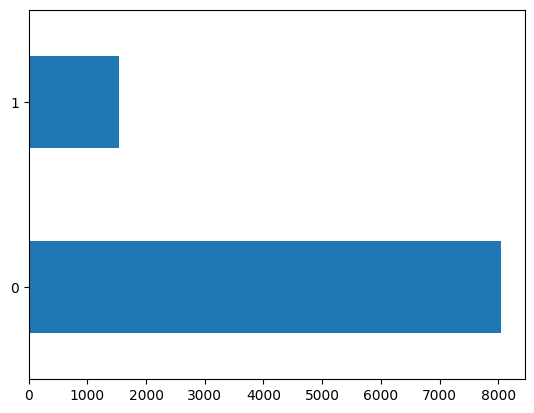

In [4]:
print(loan_data['not.fully.paid'].value_counts())
loan_data['not.fully.paid'].value_counts().plot(kind='barh')

In [5]:
loan_data_class_0 = loan_data[loan_data['not.fully.paid'] == 0]
number_class_0 = len(loan_data_class_0)
loan_data_class_1 = loan_data[loan_data['not.fully.paid'] == 1].sample(number_class_0,replace=True) # OverSampling

final_loan_data = pd.concat([loan_data_class_1, loan_data_class_0])

print(final_loan_data.shape)

(16090, 14)


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Remove unwanted 'purpose' column and get the data
final_loan_data = pd.get_dummies(final_loan_data,prefix=['purpose'],drop_first=True)
X = final_loan_data.drop('not.fully.paid', axis=1)

normalized_X = scaler.fit_transform(X)

In [7]:
y = final_loan_data['not.fully.paid']
r_state = 42
t_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(normalized_X, y,
                                                	test_size=t_size,
                                                	random_state=r_state,
                                                	stratify=y)

# **We will use different algorithms and techniques; therefore, we will create a model object to increase code reusability.**

In [8]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)
      
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

# **Random Forest Classifier**

In [9]:
# Random Forest parameters
rf_params = {
    'n_estimators': 2000,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'auto',
    'max_depth': 60,
    'bootstrap': True,
    'max_features' : 'sqrt'
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores = trainModel(rfc_model,X_train, y_train, X_test, 5, 0)
rfc_scores

(array([0.87523191, 0.88218924, 0.8877551 , 0.88497217, 0.88682746]),
 array([0, 1, 1, ..., 1, 0, 1]))

In [10]:
# Getting features importance 
rfc_features = rfc_model.feature_importances(X_train,y_train)
rfc_features

array([0.02756297, 0.12111932, 0.11048654, 0.10942885, 0.1034709 ,
       0.08346869, 0.11027893, 0.10504654, 0.1103473 , 0.058164  ,
       0.00999758, 0.00625657, 0.0084644 , 0.01430452, 0.00363835,
       0.00443139, 0.00340722, 0.01012592])

# **Extra Trees Classifier**

In [12]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 2000,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_depth': 60,
    'bootstrap': True,
    'max_features' : 'sqrt'
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores = trainModel(etc_model,X_train, y_train, X_test, 5, 0) # Random Forest
etc_scores

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



(array([0.75185529, 0.77504638, 0.79313544, 0.78478664, 0.78061224]),
 array([0, 0, 1, ..., 1, 0, 1]))

In [13]:
# Getting features importance 
etc_features = etc_model.feature_importances(X_train, y_train)
etc_features

array([0.08229966, 0.1109608 , 0.08051789, 0.07224875, 0.07502448,
       0.10359758, 0.06943797, 0.06120227, 0.08942872, 0.09005489,
       0.02787357, 0.02085888, 0.02050436, 0.03211182, 0.01204352,
       0.01422205, 0.01307895, 0.02453383])

# **LightGBM Classifier**

In [14]:
# AdaBoost parameters
lgb_params = {
    'n_jobs': -1,
    'n_estimators': 2000,
    'max_depth': 60,
}
lgb_model = ClassifierModel(clf=lgb.LGBMClassifier, params=lgb_params)
lgb_scores = trainModel(lgb_model,X_train, y_train, X_test, 5, 0) # Random Forest
lgb_scores

(array([0.92717996, 0.91372913, 0.91465677, 0.91790353, 0.92764378]),
 array([0, 0, 1, ..., 1, 0, 1]))

In [15]:
# Getting features importance 
lgb_features = lgb_model.feature_importances(X_train, y_train)
lgb_features

array([ 382, 6058, 7279, 7328, 7446, 4172, 7636, 7501, 7470, 2282,  348,
        346,  216,  840,  138,  186,  118,  254], dtype=int32)

# **Gradient Boosting Classifier**

In [16]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 2000,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_depth': 60,
    'max_features' : 1
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores = trainModel(gbc_model,X_train, y_train, X_test, 5, 0) # Random Forest
gbc_scores

(array([0.93831169, 0.93274583, 0.94294991, 0.94666048, 0.94016698]),
 array([0, 0, 0, ..., 1, 0, 1]))

In [17]:
# Getting features importance 
gbc_features = gbc_model.feature_importances(X_train,y_train)
gbc_features 

array([0.02397191, 0.12436583, 0.10652713, 0.10933975, 0.10522359,
       0.09251273, 0.11550158, 0.1082264 , 0.10045671, 0.05653988,
       0.01516517, 0.00641734, 0.00799897, 0.00852178, 0.00301614,
       0.00343997, 0.00406809, 0.00870703])

# **CatBoost Classifier**

In [18]:
# SVC parameters
cat_params = {
    'n_estimators': 2000,
    'max_depth': 60,
    'grow_policy': 'Lossguide'
}
cat_model = ClassifierModel(clf=catboost.CatBoostClassifier, params=cat_params)
cat_scores = trainModel(cat_model,X_train, y_train, X_test, 5, 0)
cat_scores

(array([0.87987013, 0.88729128, 0.88682746, 0.88914657, 0.89285714]),
 array([0, 0, 1, ..., 1, 0, 1]))

In [19]:
# Getting features importance 
cat_features = cat_model.feature_importances(X_train,y_train)
cat_features 

Learning rate set to 0.01506
0:	learn: 0.6914895	total: 62.2ms	remaining: 2m 4s
1:	learn: 0.6898710	total: 76.3ms	remaining: 1m 16s
2:	learn: 0.6883756	total: 89.8ms	remaining: 59.8s
3:	learn: 0.6866749	total: 109ms	remaining: 54.3s
4:	learn: 0.6848383	total: 123ms	remaining: 49.1s
5:	learn: 0.6834697	total: 137ms	remaining: 45.4s
6:	learn: 0.6820250	total: 151ms	remaining: 43.1s
7:	learn: 0.6804229	total: 166ms	remaining: 41.2s
8:	learn: 0.6789876	total: 180ms	remaining: 39.8s
9:	learn: 0.6775280	total: 194ms	remaining: 38.5s
10:	learn: 0.6761608	total: 211ms	remaining: 38.1s
11:	learn: 0.6748842	total: 226ms	remaining: 37.4s
12:	learn: 0.6736084	total: 238ms	remaining: 36.4s
13:	learn: 0.6724190	total: 252ms	remaining: 35.7s
14:	learn: 0.6710168	total: 266ms	remaining: 35.2s
15:	learn: 0.6698645	total: 280ms	remaining: 34.8s
16:	learn: 0.6685891	total: 295ms	remaining: 34.4s
17:	learn: 0.6671994	total: 312ms	remaining: 34.3s
18:	learn: 0.6660674	total: 326ms	remaining: 34s
19:	learn:

array([ 1.96320804, 12.58232731, 11.28353568, 11.68459054, 10.4572961 ,
        7.77383542, 11.83456357, 10.75774302, 11.22844008,  4.78290075,
        0.97970782,  0.711198  ,  0.81985961,  1.12347873,  0.35461957,
        0.44897751,  0.46912935,  0.74458891])

# **Features Importance**

In [20]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': X.columns.values,
    'Random Forest feature importances': rfc_features/sum(rfc_features),
    'Extra Trees  feature importances': etc_features,
    'LightGBM feature importances': lgb_features/sum(lgb_features),
    'Gradient Boost feature importances': gbc_features,
    'CatBoost feature importances': cat_features
    })

In [21]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.sort_values(by='mean',ascending=False)

<ipython-input-21-e2a55b58d63c>:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,features,Random Forest feature importances,Extra Trees feature importances,LightGBM feature importances,Gradient Boost feature importances,CatBoost feature importances,mean
1,int.rate,0.121119,0.110961,0.100967,0.124366,12.582327,2.607948
6,days.with.cr.line,0.110279,0.069438,0.127267,0.115502,11.834564,2.451410
3,log.annual.inc,0.109429,0.072249,0.122133,0.109340,11.684591,2.419548
2,installment,0.110487,0.080518,0.121317,0.106527,11.283536,2.340477
8,revol.util,0.110347,0.089429,0.124500,0.100457,11.228440,2.330635
7,revol.bal,0.105047,0.061202,0.125017,0.108226,10.757743,2.231447
4,dti,0.103471,0.075024,0.124100,0.105224,10.457296,2.173023
5,fico,0.083469,0.103598,0.069533,0.092513,7.773835,1.624590
9,inq.last.6mths,0.058164,0.090055,0.038033,0.056540,4.782901,1.005139
0,credit.policy,0.027563,0.082300,0.006367,0.023972,1.963208,0.420682


In [22]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values

In [38]:
acc_pred_train = pd.DataFrame ({'RandomForest': rfc_scores[0],
     'ExtraTrees': etc_scores[0],
     'LightGBM': lgb_scores[0],
      'GradientBoost': gbc_scores[0],
      'CatBoost': cat_scores[0],
    })
acc_pred_train.head()

,RandomForest,ExtraTrees,LightGBM,GradientBoost,CatBoost
0,0.875232,0.751855,0.927180,0.938312,0.879870
1,0.882189,0.775046,0.913729,0.932746,0.887291
2,0.887755,0.793135,0.914657,0.942950,0.886827
3,0.884972,0.784787,0.917904,0.946660,0.889147
4,0.886827,0.780612,0.927644,0.940167,0.892857


Now let's see if it's better to build an XGBoost model that trains only the predictions received. But before that, let's take a quick look at the correlation between classifier predictions.

<Axes: title={'center': 'Pearson correlation of features'}>

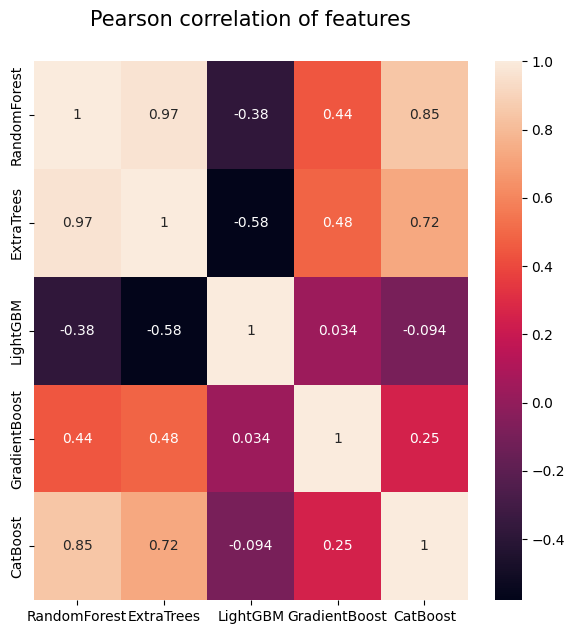

In [24]:
colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)

Let's combine all the 5-fold cross-validation accuracies of the model and build a stacking model where a new, more powerful model learns the predictions of all these weak learners. The label vector used to train the previous model remains the same. Features are the predictions received from each classifier.

In [39]:
x_train = np.column_stack((etc_scores[1], rfc_scores[1], lgb_scores[1], gbc_scores[1], cat_scores[1]))

In [32]:
x_train.shape

(10780, 4)

In [27]:
acc_pred_train

,RandomForest,ExtraTrees,LightGBM,GradientBoost,CatBoost
0,0.875232,0.751855,0.927180,0.938312,0.879870
1,0.882189,0.775046,0.913729,0.932746,0.887291
2,0.887755,0.793135,0.914657,0.942950,0.886827
3,0.884972,0.784787,0.917904,0.946660,0.889147
4,0.886827,0.780612,0.927644,0.940167,0.892857


The default classifier created previously represents a level 0 model and the new XGBoost model represents a level 1 model. The combination shows a meta-model trained on sample data predictions. Here's a quick comparison of the accuracy of the new summation model and the default classifier:

In [40]:
def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds)
    gbm = xgb.XGBClassifier(
     n_estimators= 2000,
     max_depth= 16,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [41]:
stackModel_scores = trainStackModel(x_train, y_train, X_test, 5, 0)

In [42]:
acc_pred_train['stackingModel'] = stackModel_scores
acc_pred_train.loc['mean'] = acc_pred_train.mean()
acc_pred_train

,RandomForest,ExtraTrees,LightGBM,GradientBoost,CatBoost,stackingModel
0,0.875232,0.751855,0.927180,0.938312,0.879870,0.951299
1,0.882189,0.775046,0.913729,0.932746,0.887291,0.945733
2,0.887755,0.793135,0.914657,0.942950,0.886827,0.950835
3,0.884972,0.784787,0.917904,0.946660,0.889147,0.959184
4,0.886827,0.780612,0.927644,0.940167,0.892857,0.955937
mean,0.883395,0.777087,0.920223,0.940167,0.887199,0.952597


# **Important Considerations**

**Noise, Bias and Variance**. Combining solutions from multiple models can help improve overall performance. Therefore, one of the key factors in using ensemble models is overcoming issues such as noise, bias, and variance. If ensemble models do not provide collective experience to improve accuracy in such situations, careful rethinking of their application is warranted.

**Simplicity and explainability**. Machine learning models, especially those deployed in production, prefer simple over complex. The ability to describe the final model solution is empirically reduced by the ensemble.

**Generalizations**: There are many claims that ensemble models have more ability to generalize, but other reported use cases have shown more generalization errors. Therefore, it is very likely that ensemble models with no careful training process can quickly produce high overfitting models.

**Inference Time**: Although we might be relaxed to accept a longer time for model training, inference time is still critical. When deploying ensemble models into production, the amount of time needed to pass multiple models increases and could slow down the prediction tasks’ throughput.

**Summary**
Ensemble models is an excellent method for machine learning. Ensemble models have many methods for classification and regression problems. We discovered the types of such models, how to build simple ensemble models, and how to increase the accuracy of the models.